# Models

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# models
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import F1Score

# eval utils
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score

ImportError: cannot import name 'F1Score' from 'tensorflow.keras.metrics' (C:\Users\HedonisT\anaconda3\envs\internship\lib\site-packages\keras\api\_v2\keras\metrics\__init__.py)

In [61]:
df = pd.read_csv('data/cats-no-breed-info.csv').drop(columns=['id', 'breed', 'color'])
df.head()

,age_upon_intake_years,time_in_shelter_days,intake_weekday_friday,intake_weekday_monday,intake_weekday_saturday,intake_weekday_sunday,intake_weekday_thursday,intake_weekday_tuesday,intake_weekday_wednesday,intake_month_1,...,intake_condition_nursing,intake_condition_other,intake_condition_pregnant,intake_condition_sick,sex_female,sex_male,reproductive_state_intake_intact,reproductive_state_intake_sterile,reproductive_state_outcome_intact,reproductive_state_outcome_sterile
0,0.727273,3.897222,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
1,0.636364,14.120139,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
2,0.863636,0.067361,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
3,0.545455,0.200694,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
4,0.590909,4.804861,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,1,0,1


In [62]:
def get_time_period_labels_from_bins(bins):
    n_bins = len(bins)
    labels = []
    for i in range(n_bins - 1):
        label = f'{bins[i]}-{bins[i+1]} days' if i != n_bins - 2 else f'> {bins[i]} days'
        labels.append(label)
    return labels
    
def print_report(y_true, y_pred, target_names):
    print(classification_report(y_true, y_pred, target_names=target_names))
    print(confusion_matrix(y_true, y_pred))

In [63]:
bins = (0, 7, 30, 60, 90, 120, df['time_in_shelter_days'].max() + 1)

def bin_target(target):
    return np.digitize(target, bins) - 1

In [64]:
target_labels = get_time_period_labels_from_bins(bins)
target_labels

['0-7 days',
 '7-30 days',
 '30-60 days',
 '60-90 days',
 '90-120 days',
 '> 120 days']

In [65]:
df['target'] = bin_target(df['time_in_shelter_days'])
train, test = train_test_split(df, test_size=0.1, stratify=df['target'], random_state=0)

X_train, y_train_orig = train.drop(columns=['time_in_shelter_days', 'target']), train['time_in_shelter_days']
X_test, y_test_orig = test.drop(columns=['time_in_shelter_days', 'target']), test['time_in_shelter_days']

y_train, y_test = bin_target(y_train_orig), bin_target(y_test_orig)

## Random search evaluation pipeline

In [66]:
def rs_pipeline(clf, param_grid, X_train, y_train, X_test, y_test, metrics='f1_macro'):
    cv = StratifiedKFold(n_splits=10)

    clf_cv = RandomizedSearchCV(clf, param_grid, scoring=metrics, cv=cv, verbose=3)
    clf_cv.fit(X_train, y_train)

    print("Best parameters:", clf_cv.best_params_)
    print("Best score:", clf_cv.best_score_)
    
    print_report(y_test, clf_cv.predict(X_test), target_labels)
    return clf_cv

## Cross validate pipeline

In [78]:
def cv_pipeline(clf, X_train, y_train, metrics=['f1_macro']):
    cv = StratifiedKFold(n_splits=10)

    clf_cv = cross_validate(clf, X_train, y_train, scoring=metrics, cv=cv, verbose=3)

    for metric in metrics:
        print(f"AVG TEST {metric}: {np.mean(clf_cv[f'test_{metric}'])}")
        
    print_report(y_test, clf.predict(X_test), target_labels)

## Base model - imbalanced dataset - simple multiclass classification

### Random Forest

In [57]:
# rf_params = {
#     'n_estimators': [20, 50, 100, 150],
#     'max_depth': [3, 5, 10],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'bootstrap': [True, False]
# }

# rf = RandomForestClassifier(random_state=0)
# best_rf = rs_pipeline(rf, rf_params, X_train, y_train, X_test, y_test)

best_rf = RandomForestClassifier(**{'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}, random_state=0)
cv_pipeline(best_rf, X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................. f1_macro: (test=0.317) total time=   3.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] END ............................. f1_macro: (test=0.315) total time=   3.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s


[CV] END ............................. f1_macro: (test=0.298) total time=   3.6s
[CV] END ............................. f1_macro: (test=0.315) total time=   3.6s
[CV] END ............................. f1_macro: (test=0.310) total time=   3.6s
[CV] END ............................. f1_macro: (test=0.303) total time=   3.9s
[CV] END ............................. f1_macro: (test=0.314) total time=   3.7s
[CV] END ............................. f1_macro: (test=0.325) total time=   3.8s
[CV] END ............................. f1_macro: (test=0.318) total time=   3.9s
[CV] END ............................. f1_macro: (test=0.309) total time=   3.7s
AVG TEST f1_macro: 0.3124845555406547


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   38.3s finished


### Gradient Boosting

In [70]:
# gb_params = {
#     'learning_rate': [0.05, 0.1, 0.2],
#     'n_estimators': [20, 50, 100],
#     'max_depth': [3, 5, 10],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'subsample': [0.8, 0.9, 1.0]
# }

# gb = GradientBoostingClassifier(random_state=0)
# best_gb = rs_pipeline(gb, gb_params, X_train, y_train, X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................. f1_macro: (test=0.406) total time= 1.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[CV] END ............................. f1_macro: (test=0.427) total time= 1.6min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min remaining:    0.0s


[CV] END ............................. f1_macro: (test=0.383) total time= 1.6min
[CV] END ............................. f1_macro: (test=0.397) total time= 1.6min
[CV] END ............................. f1_macro: (test=0.428) total time= 1.7min
[CV] END ............................. f1_macro: (test=0.408) total time= 1.8min
[CV] END ............................. f1_macro: (test=0.378) total time= 1.9min
[CV] END ............................. f1_macro: (test=0.411) total time= 2.2min
[CV] END ............................. f1_macro: (test=0.397) total time= 2.0min
[CV] END ............................. f1_macro: (test=0.428) total time= 1.9min
AVG TEST f1_macro: 0.40628044948439346


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 18.0min finished


In [ ]:
best_gb = GradientBoostingClassifier(learning_rate=0.05, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8, random_state=0)
cv_pipeline(best_gb, X_train, y_train)

### XGBoost

In [76]:
# xgb_params = {
#     'learning_rate': [0.05, 0.1, 0.2],
#     'n_estimators': [20, 50, 100],
#     'max_depth': [3, 5, 10],
#     'subsample': [0.8, 0.9, 1.0]
# }

# xgb = XGBClassifier(objective="multi:softprob", random_state=0)
# best_xgb = pipeline(xgb, xgb_params, X_train, y_train, X_test, y_test)

TypeError: __init__() got an unexpected keyword argument 'subsample'

In [77]:
best_xgb =  XGBClassifier(**{'subsample': 1.0, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2}, random_state=0)
cv_pipeline(best_xgb, X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................. f1_macro: (test=0.415) total time=  21.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s remaining:    0.0s


[CV] END ............................. f1_macro: (test=0.425) total time=  28.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.2s remaining:    0.0s


[CV] END ............................. f1_macro: (test=0.375) total time=  23.5s
[CV] END ............................. f1_macro: (test=0.392) total time=  23.0s
[CV] END ............................. f1_macro: (test=0.421) total time=  24.8s
[CV] END ............................. f1_macro: (test=0.398) total time=  23.0s
[CV] END ............................. f1_macro: (test=0.384) total time=  22.8s
[CV] END ............................. f1_macro: (test=0.423) total time=  23.3s
[CV] END ............................. f1_macro: (test=0.406) total time=  22.6s
[CV] END ............................. f1_macro: (test=0.411) total time=  23.9s
AVG TEST f1_macro: 0.4049888673443176


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.0min finished


AttributeError: 'dict' object has no attribute 'predict'

### ANN

In [114]:
ann = Sequential()
ann.add(Dense(20, input_shape=(X_train.shape[1], ), activation='relu'))
ann.add(Dense(10, activation='relu'))
ann.add(Dense(len(bins) - 1, activation='softmax'))

In [115]:
def f1_macro(y_true, y_pred):
    y_true = np.argmax(y_true.numpy(), axis=-1)
    y_pred = np.argmax(y_pred.numpy(), axis=-1)
    return f1_score(y_true, y_pred, average="macro")

In [116]:
ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_macro], run_eagerly=True)

In [109]:
# keeping ratio 0.8, 0.1, 0.1 - train, validation, test
ratio_train = 0.8
ratio_val = 0.1
ratio_test = 0.1

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

In [119]:
hist = ann.fit(X_train, to_categorical(y_train), epochs=150, batch_size=10, validation_split=ratio_val_adjusted)

Epoch 1/150
  14/2364 [..............................] - ETA: 9:33 - loss: 1.3484 - f1_macro: 0.20

KeyboardInterrupt: 

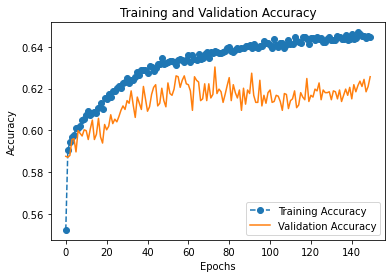

In [78]:
plt.plot(hist.history['f1_macro'], 'o--', label='Training f1_macro')
plt.plot(hist.history['val_f1_macro'], '-', label='Validation f1_macro')

# add axis labels and title
plt.xlabel('Epochs')
plt.ylabel('f1_macro')
plt.title('Training and Validation Accuracy')

# add legend
plt.legend()

# show the plot
plt.show()

In [112]:
print_report(y_test, np.argmax(ann.predict(X_test), axis=-1), target_labels)

              precision    recall  f1-score   support

    0-7 days       0.73      0.82      0.77      1591
   7-30 days       0.39      0.28      0.33       711
  30-60 days       0.34      0.59      0.43       386
  60-90 days       0.00      0.00      0.00       154
 90-120 days       0.00      0.00      0.00        53
  > 120 days       0.00      0.00      0.00        59

    accuracy                           0.59      2954
   macro avg       0.24      0.28      0.26      2954
weighted avg       0.53      0.59      0.55      2954

[[1311  166  114    0    0    0]
 [ 340  197  174    0    0    0]
 [  82   78  226    0    0    0]
 [  32   33   89    0    0    0]
 [  13    8   32    0    0    0]
 [  15   17   27    0    0    0]]


C:\Users\HedonisT\anaconda3\envs\internship\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HedonisT\anaconda3\envs\internship\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HedonisT\anaconda3\envs\internship\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

## Cascading bins waterfall model

In [106]:
import collections.abc

def isMonotonicallyIncreasing(array):
    a = np.array(array)
    return np.all(a[:-1] < a[1:])
    
class CBWM:
    def __init__(
        self, 
        bins, 
        models = lambda : GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0),
    ):
        if isinstance(bins, str) or not hasattr(bins, '__len__'):
            raise TypeError('bins must be Sequence')
        if len(bins) == 0:
            raise ValueError('bins cannot be empty Sequence')
        if not isMonotonicallyIncreasing(bins):
            raise ValueError('bins must be monotonically increasing Sequence')
        
        self.bins = bins
        
        if not isinstance(models, str) and hasattr(models, '__len__'):
            if (len(models) == len(self.bins) - 2):
                self.models = models
            else:
                raise ValueError('len(models) == len(self.bins) - 2')
        elif (callable(models)):
            self.models = [models() for _ in range(len(self.bins) - 2)]
        else:
            raise TypeError('models must be Sequence or callable (model factory)')
        
        
    def fit(self, X, y):
        x_next = X
        y_next = y
        for bin_edge, model in zip(self.bins[1:-1], self.models):
            y_bin = (y_next < bin_edge).astype(int)

            model.fit(x_next, y_bin)
            
            next_idx = y_bin == 0
            x_next = x_next[next_idx]
            y_next = y_next[next_idx]
            
    def predict(self, X):
        y_shape = (X.shape[0], )
        y_pred = np.full(y_shape, 0, dtype=int)
        
        for idx, model in enumerate(self.models):
            pred_not_done = y_pred == 0
            if not pred_not_done.any():
                break
            pred_done = model.predict(X[pred_not_done]) == 1
            y_pred[pred_not_done] = pred_done.astype(int) * (idx + 1)
        
        y_pred[y_pred==0] = len(self.models) + 1
        
        return y_pred - 1


In [107]:
cmwm = CBWM(bins)
cmwm.fit(X_train, y_train_orig)
print_report(y_test, cmwm.predict(X_test), target_labels)

              precision    recall  f1-score   support

    0-7 days       0.77      0.82      0.79      1591
   7-30 days       0.41      0.40      0.40       711
  30-60 days       0.46      0.55      0.50       386
  60-90 days       0.46      0.24      0.32       154
 90-120 days       0.20      0.06      0.09        53
  > 120 days       0.14      0.07      0.09        59

    accuracy                           0.62      2954
   macro avg       0.41      0.35      0.37      2954
weighted avg       0.60      0.62      0.61      2954

[[1303  230   46    6    3    3]
 [ 316  281   96    8    0   10]
 [  48  100  212   16    2    8]
 [  13   36   63   37    3    2]
 [   8    9   23    9    3    1]
 [   8   22   17    4    4    4]]


In [ ]:
models = [
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0),
    SVC(C=1.0, random_state=0),
]
cmwm = CBWM(bins, models)
cmwm.fit(X_train, y_train_orig)
print_report(y_test, cmwm.predict(X_test), target_labels)

# SMOTE

In [81]:
from imblearn.over_sampling import SMOTE

<AxesSubplot:title={'center':'Class distribution before SMOTE'}>

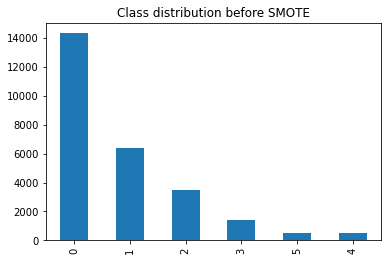

In [79]:
pd.Series(y_train).value_counts().plot(kind='bar', title='Class distribution before SMOTE')

<AxesSubplot:title={'center':'Class distribution after appying SMOTE'}>

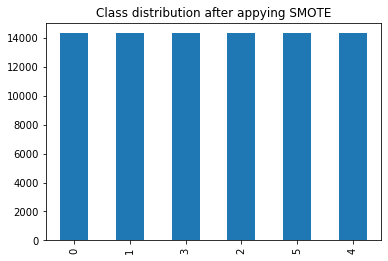

In [82]:
X_resampled, y_resampled = SMOTE(random_state=0).fit_resample(X_train, y_train)
pd.Series(y_resampled).value_counts().plot(kind='bar', title='Class distribution after appying SMOTE')

In [87]:
best_rf_smote = RandomForestClassifier(**{'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}, random_state=0)
best_rf_smote.fit(X_resampled, y_resampled)
print_report(y_test, best_rf_smote.predict(X_test), target_labels)

              precision    recall  f1-score   support

    0-7 days       0.72      0.90      0.80      1591
   7-30 days       0.44      0.36      0.40       711
  30-60 days       0.48      0.49      0.49       386
  60-90 days       0.64      0.05      0.08       154
 90-120 days       0.00      0.00      0.00        53
  > 120 days       0.00      0.00      0.00        59

    accuracy                           0.63      2954
   macro avg       0.38      0.30      0.29      2954
weighted avg       0.59      0.63      0.59      2954

[[1425  149   17    0    0    0]
 [ 400  254   57    0    0    0]
 [  93  102  189    2    0    0]
 [  35   32   80    7    0    0]
 [   9   12   29    2    0    1]
 [  12   24   21    0    2    0]]


In [120]:
best_gb_smote = GradientBoostingClassifier(learning_rate=0.05, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8, random_state=0)
best_gb_smote.fit(X_resampled, y_resampled)
print_report(y_test, best_gb_smote.predict(X_test), target_labels)

              precision    recall  f1-score   support

    0-7 days       0.80      0.77      0.78      1591
   7-30 days       0.45      0.47      0.46       711
  30-60 days       0.46      0.51      0.48       386
  60-90 days       0.34      0.32      0.33       154
 90-120 days       0.11      0.09      0.10        53
  > 120 days       0.11      0.12      0.11        59

    accuracy                           0.61      2954
   macro avg       0.38      0.38      0.38      2954
weighted avg       0.62      0.61      0.62      2954

[[1221  278   46   17   10   19]
 [ 232  335   93   23    9   19]
 [  42   81  195   41   12   15]
 [  13   32   49   50    8    2]
 [   7    9   20   10    5    2]
 [   5   17   20    7    3    7]]


In [ ]:
best_xgb_smote =  XGBClassifier(**{'subsample': 1.0, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2}, random_state=0)
best_xgb_smote.fit(X_resampled, y_resampled)
print_report(y_test, best_gb_smote.predict(X_test), target_labels)

In [74]:
ann_smote = Sequential()
ann_smote.add(Dense(20, input_shape=(X_train.shape[1], ), activation='relu'))
ann_smote.add(Dense(10, activation='relu'))
ann_smote.add(Dense(len(bins) - 1, activation='softmax'))
ann_cmote.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['f1_score'], run_eagerly=True)

In [75]:
hist = ann.fit(X_train, to_categorical(y_train), epochs=150, batch_size=10, validation_split=ratio_val_adjusted)

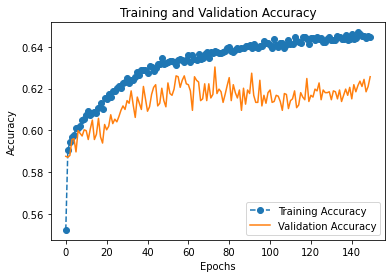

In [78]:
plt.plot(hist.history['accuracy'], 'o--', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], '-', label='Validation Accuracy')

# add axis labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# add legend
plt.legend()

# show the plot
plt.show()